In [1]:
from utils import read_table
df_1 = read_table()
df_1

,event_uid,user_uid,popcorn_id_1,popcorn_id_2,score,timestamp
0,1,zxc,1,2,0.5,123


In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(399)

popcorn = range(12)
people = range(80)
num_matchups = 1000
person_id_1 = np.random.choice(people, num_matchups)
person_id_2 = np.random.choice(people, num_matchups)
popcorn_id_1 = np.random.choice(popcorn, num_matchups)
popcorn_id_2 = np.random.choice(popcorn, num_matchups)



with pm.Model(coords={"popcorn": popcorn, "people": people}) as model:
    mu_popcorn = pm.ZeroSumNormal("mu_popcorn", sigma=.5, dims="popcorn")
    person_popcorn_interaction = pm.ZeroSumNormal("person_popcorn_interaction", sigma=0.2, dims=["people", "popcorn"])

    popcorn_rating = pm.Normal("popcorn_rating", mu=mu_popcorn + person_popcorn_interaction, sigma=0.1, dims=["people", "popcorn"])

    rating_diff = pm.Deterministic("rating_diff", popcorn_rating[person_id_1, popcorn_id_1] - popcorn_rating[person_id_2, popcorn_id_2])

In [3]:
with model:
    prior_predictive_trace = pm.sample_prior_predictive(100)

Sampling: [mu_popcorn, person_popcorn_interaction, popcorn_rating]


array([[<Axes: title={'center': 'popcorn_rating'}>,
        <Axes: title={'center': 'popcorn_rating'}>],
       [<Axes: title={'center': 'mu_popcorn'}>,
        <Axes: title={'center': 'mu_popcorn'}>],
       [<Axes: title={'center': 'rating_diff'}>,
        <Axes: title={'center': 'rating_diff'}>],
       [<Axes: title={'center': 'person_popcorn_interaction'}>,
        <Axes: title={'center': 'person_popcorn_interaction'}>]],
      dtype=object)

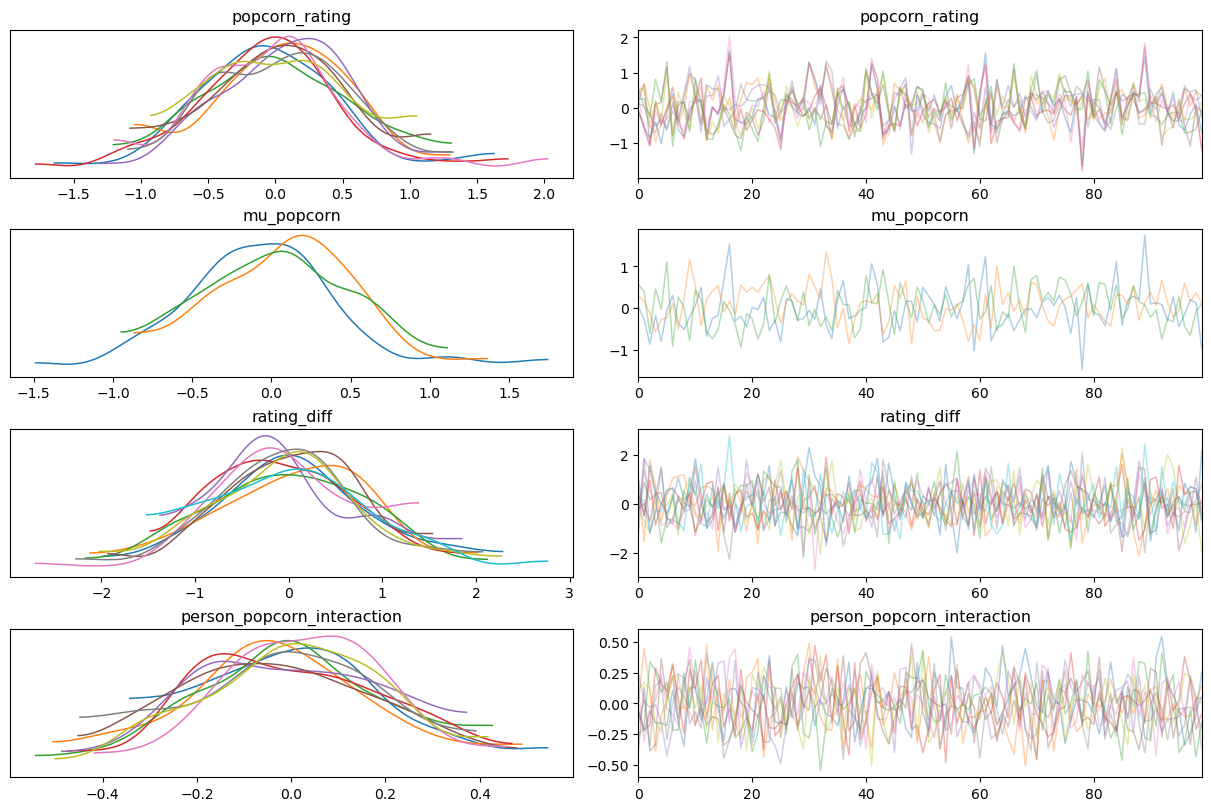

In [4]:
import arviz as az
az.plot_trace(prior_predictive_trace.prior, coords={"popcorn": [0, 1, 2], "people": [0, 1, 2], "rating_diff_dim_0": range(10)})

In [5]:
a = np.random.randint(10, size=(5,4))
print(a)
a[[0,1], [2, 3]]

[[6 3 2 6]
 [4 7 3 1]
 [4 9 9 2]
 [6 8 9 6]
 [6 8 1 1]]


array([2, 1])

In [6]:
sample = prior_predictive_trace.prior.sel(chain=0, draw=0)
synthetic_df = pd.DataFrame(
    {
        "person_1": person_id_1,
        "person_2": person_id_2,
        "popcorn_1": popcorn_id_1,
        "popcorn_2": popcorn_id_2,
        "rating_diff": np.clip(sample["rating_diff"], -2, 2)
    }
)
synthetic_popcorn_ratings = sample["popcorn_rating"]

synthetic_df.head()

,person_1,person_2,popcorn_1,popcorn_2,rating_diff
0,78,48,10,4,0.987818
1,71,31,5,8,0.849716
2,70,68,7,9,-0.287590
3,21,26,5,10,0.409671
4,35,18,8,5,-1.255690


In [7]:
sample.mu_popcorn[:3]

<xarray.DataArray 'mu_popcorn' (popcorn: 3)>
array([0.0320946 , 0.30401611, 0.57003948])
Coordinates:
    chain    int64 0
    draw     int64 0
  * popcorn  (popcorn) int64 0 1 2

In [8]:
with pm.Model(coords={"popcorn": popcorn, "people": people}) as model:
    sigma_popcorn = pm.Exponential("sigma_popcorn", 1)
    mu_popcorn = pm.ZeroSumNormal("mu_popcorn", sigma=sigma_popcorn, dims="popcorn")
    sigma_interaction = pm.Exponential("sigma_interaction", 1/.3)
    person_popcorn_interaction = pm.ZeroSumNormal("person_popcorn_interaction", sigma=sigma_interaction, dims=["people", "popcorn"])

    popcorn_rating = pm.Deterministic("popcorn_rating", mu_popcorn + person_popcorn_interaction)


    rating_diff = pm.Deterministic("rating_diff", popcorn_rating[person_id_1, popcorn_id_1] - popcorn_rating[person_id_2, popcorn_id_2])

    # sigma_observation = pm.Exponential("sigma_observation", 1/.3)
    sigma_observation = .1
    # observed_rating_diff_raw = pm.Normal.dist(mu=rating_diff, sigma=sigma_observation)
    # observed_rating_diff = pm.Censored("observed_rating_diff", observed_rating_diff_raw, lower=-2, upper=2, observed=synthetic_df["rating_diff"])
    observed_rating_diff = pm.TruncatedNormal("observed_rating_diff", mu=rating_diff, sigma=sigma_observation, lower=-2, upper=2, observed=synthetic_df["rating_diff"])

In [9]:
with model:
    trace = pm.sample(1000, tune=1000)

# az.plot_trace(trace, coords={"popcorn": [0, 1, 2, 3, 4, 5], "people": [0, 1, 2, 3, 4, 5]})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_popcorn, mu_popcorn, sigma_interaction, person_popcorn_interaction]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


array([[<Axes: title={'center': 'sigma_popcorn'}>,
        <Axes: title={'center': 'sigma_popcorn'}>],
       [<Axes: title={'center': 'mu_popcorn'}>,
        <Axes: title={'center': 'mu_popcorn'}>],
       [<Axes: title={'center': 'sigma_interaction'}>,
        <Axes: title={'center': 'sigma_interaction'}>],
       [<Axes: title={'center': 'person_popcorn_interaction'}>,
        <Axes: title={'center': 'person_popcorn_interaction'}>],
       [<Axes: title={'center': 'popcorn_rating'}>,
        <Axes: title={'center': 'popcorn_rating'}>],
       [<Axes: title={'center': 'rating_diff'}>,
        <Axes: title={'center': 'rating_diff'}>]], dtype=object)

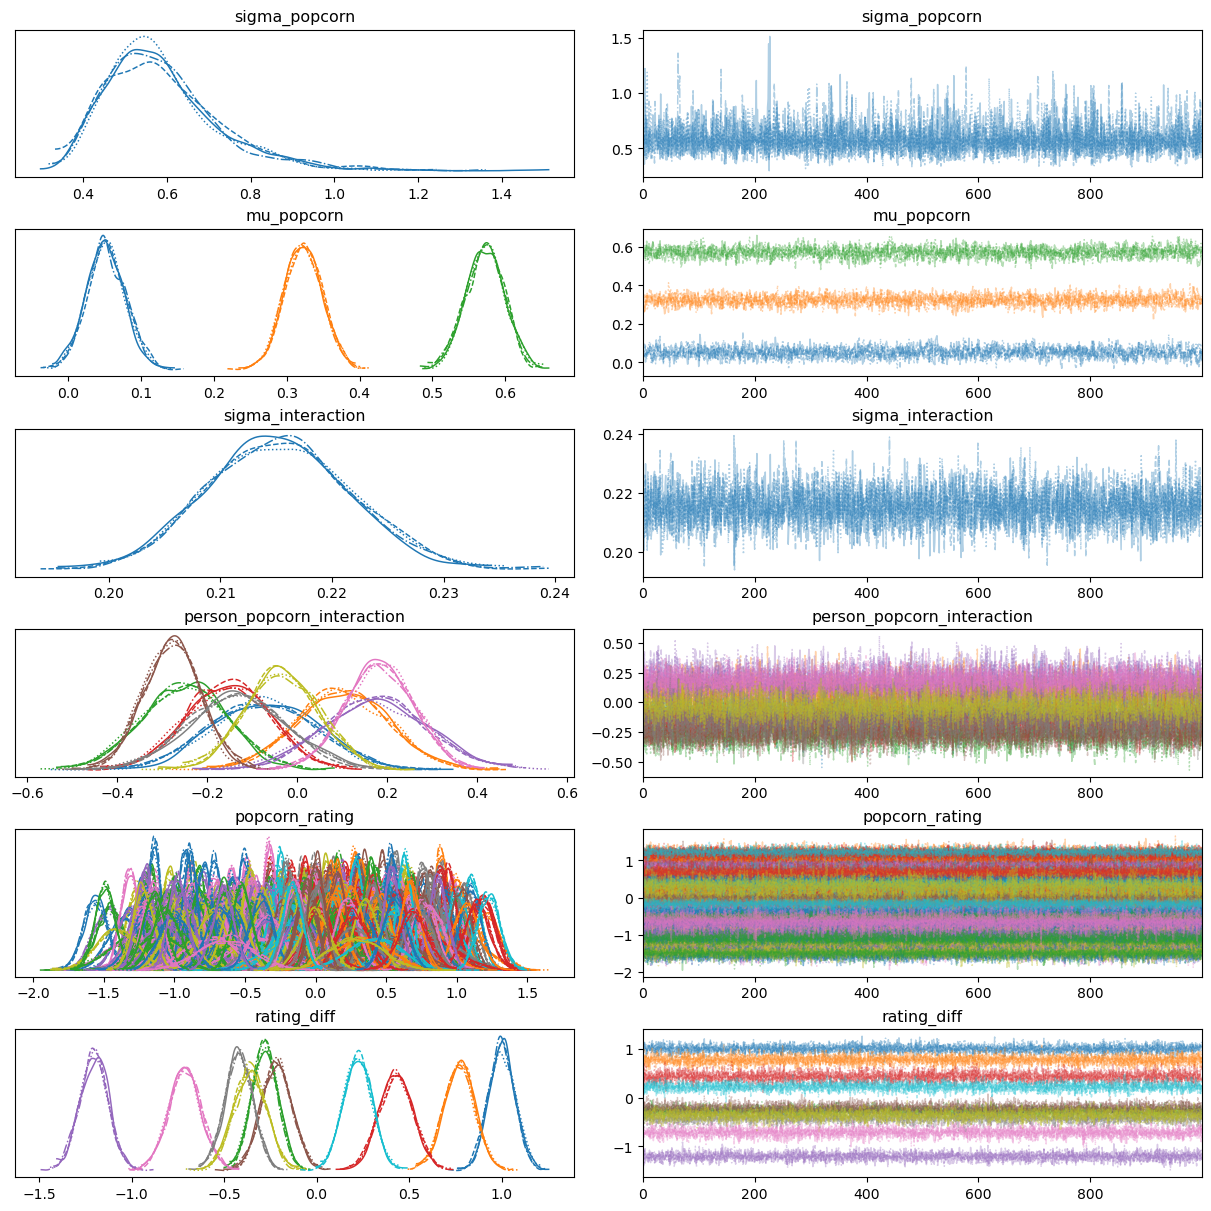

In [10]:
az.plot_trace(trace, coords={"popcorn": [0, 1, 2], "people": [0, 1, 2], "rating_diff_dim_0": range(10)})


Sampling: [observed_rating_diff]


/home/erik/miniforge3/envs/pymc_env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<Axes: xlabel='observed_rating_diff / observed_rating_diff'>

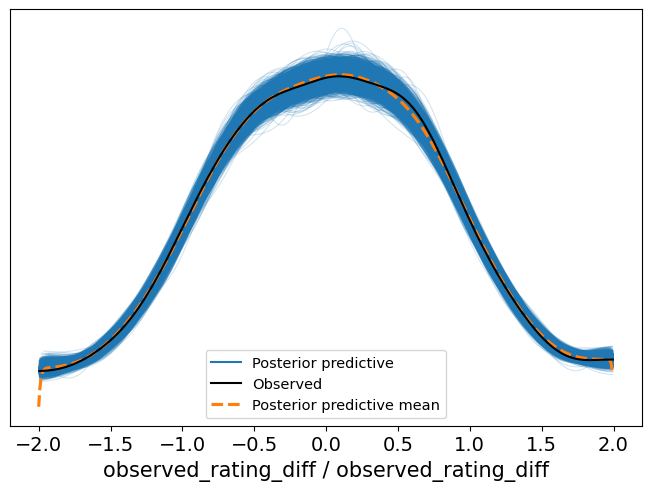

In [11]:
with model:
    pp = pm.sample_posterior_predictive(trace)

az.plot_ppc(pp)

In [12]:
np.abs(trace.posterior.popcorn_rating - synthetic_popcorn_ratings).mean()

MemoryError: Unable to allocate 27.5 GiB for an array with shape (4, 1000, 80, 12, 80, 12) and data type float64

In [ ]:
.32064182

0.32064182

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data